<a href="https://colab.research.google.com/github/thayssa1186/IntelImageClassification/blob/master/intelimgclassification001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
###### import libs to pip  ##########
#!pip install keras
#!pip install tensorflow-gpu
#!pip install opencv-python
#!pip install matplotlib


In [0]:
##### imports ########
import tensorflow.keras.models as Models
from tensorflow.keras.models import Model
import tensorflow.keras.layers as Layers
import tensorflow.keras.optimizers as Optimizer
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.utils import plot_model

from google.colab import drive
import matplotlib.pyplot as plot
import matplotlib
import cv2
import numpy as np
import os
from random import randint

from sklearn.metrics import confusion_matrix
import seaborn as sn   

%matplotlib inline



In [0]:
# Load the Drive helper and mount
# This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)
#!ls "/content/drive/My Drive"

os.chdir('/content/drive/My Drive/Datasets/intel-image-classification/')  #change dir
#!unzip intel-image-classification.zip
#!mkdir seg_train  #create a directory named seg_train/
#!mkdir seg_test  #create a directory named seg_test/
#!mkdir seg_pred  #create a directory named seg_pred/

#!unzip seg_train.zip #unzip data in train/
#unzip seg_test.zip  #unzip data in test/
#!unzip seg_pred.zip  #unzip data in test/

Mounted at /content/drive


In [0]:
#!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
#!unzip ngrok-stable-linux-amd64.zip

--2019-08-27 23:42:10--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.86.186.182, 52.201.75.180, 52.23.2.88, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.86.186.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13607069 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  12.98M  5.92MB/s    in 2.2s    

2019-08-27 23:42:13 (5.92 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13607069/13607069]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.6/json/__init__.py", line 299, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/usr/lib/python3.6/json/__init__.py", line 354, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.6/json/decoder.py", line 339, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.6/json/decoder.py", line 357, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


In [0]:
########## Load Imagens ####################

def get_images_labels(directory):
  Images = []
  Labels = []  
  label = 0

  for labels in os.listdir(directory): # diretorios das imagens que possuem nomes das classes.
      if labels == 'glacier': 
          label = 2
      elif labels == 'sea':
          label = 4
      elif labels == 'buildings':
          label = 0
      elif labels == 'forest':
          label = 1
      elif labels == 'street':
          label = 5
      elif labels == 'mountain':
          label = 3

      for image_file in os.listdir(directory+labels): # extrai imagens
          image = cv2.imread(directory+labels+r'/'+image_file) # lê imagens (OpenCV)
          image = cv2.resize(image,(150,150)) # "resize" imagens
          Images.append(image)
          Labels.append(label)
  print(Images.
  
  return (Images,Labels) 


In [0]:
def get_images(directory):
    Images = []
   
    for image_file in os.listdir(directory): # extrai imagens
        image = cv2.imread(directory+'/'+image_file) # lê imagens (OpenCV)
        image = cv2.resize(image,(150,150)) # "resize" imagens
        Images.append(image)

    return (Images) 

In [0]:
def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
    
    return labels[class_code]

In [0]:
def plot_images():

    Images, Labels = get_images_labels('/content/drive/My Drive/Datasets/intel-image-classification/seg_train/') # extrai imagens de treinamento

    Images = np.array(Images) # converte lista de imagens para numpy array.
    Labels = np.array(Labels)

    f,ax = plot.subplots(5,5) 
    for i in range(0,5,1):
        for j in range(0,5,1):
            index = randint(0,len(Images))
            ax[i,j].imshow(Images[index])
            ax[i,j].set_title(get_classlabel(Labels[index]))
            ax[i,j].axis('off')
    plot.show()

In [0]:
def pie_plot():

    class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

    Images, Labels = get_images_labels('/content/drive/My Drive/Datasets/intel-image-classification/seg_train/') 
    Labels = np.array(Labels)

    sizes = np.bincount(Labels)
    explode = (0, 0, 0, 0, 0, 0)  
    plot.pie(sizes, explode=explode, labels=class_names, autopct='%1.1f%%', shadow=True, startangle=150)
    plot.axis('equal')
    plot.title('Porcentagem de Imagens por Categoria')

    plot.show()

In [0]:
################## Model Train ###################################

def get_Model_Sequential_Completo():
 
    model = Models.Sequential()

    model.add(Layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
    model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
    model.add(Layers.MaxPool2D(5,5))
    model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
    model.add(Layers.Conv2D(140,kernel_size=(3,3),activation='relu'))
    model.add(Layers.Conv2D(100,kernel_size=(3,3),activation='relu'))
    model.add(Layers.Conv2D(50,kernel_size=(3,3),activation='relu'))
    model.add(Layers.MaxPool2D(5,5))
    model.add(Layers.Flatten())
    model.add(Layers.Dense(180,activation='relu'))
    model.add(Layers.Dense(100,activation='relu'))
    model.add(Layers.Dense(50,activation='relu'))
    model.add(Layers.Dropout(rate=0.5))
    model.add(Layers.Dense(6,activation='softmax'))

    model.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    model.summary()

    return model

In [0]:
def plot_Model_Sequential_Completo():

    model = get_Model_Sequential_Completo()

    plot_model(model,to_file='modelo_completo.png',show_shapes=True)

    model_image = cv2.imread('modelo_completo.png')
    model_image_np = np.array(model_image)

    f,ax = plot.subplots(1,1) 
    ax.imshow(model_image_np)
    ax.set_title('Modelo Completo')
    ax.axis('off')
    plot.show()

In [0]:
def fit_Model_Sequential_Completo():

    Images, Labels = get_images_labels('/content/drive/My Drive/Datasets/intel-image-classification/seg_train/') 

    Images = np.array(Images) # converte lista de imagens para numpy array.
    Labels = np.array(Labels)
    
    class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

    sizes = np.bincount(Labels)
    explode = (0, 0, 0, 0, 0, 0)  
    plot.pie(sizes, explode=explode, labels=class_names, autopct='%1.1f%%', shadow=True, startangle=150)
    plot.axis('equal')
    plot.title('Porcentagem de Imagens por Categoria')

    plot.show()

    few_images = Images[1:300]
    few_labels = Labels[1:300]

    model = get_Model_Sequential_Completo()

    checkpoint = ModelCheckpoint('weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]

    trained = model.fit(few_images,few_labels,batch_size=10,epochs=4,validation_split=0.30,callbacks=callbacks_list)

    # trained = model.fit(few_images,few_labels,batch_size=10,epochs=4,validation_split=0.30)

    model.save('modelo_completo.hd5')
    model.save_weights('modelo_completo_pesos.hd5')

    plot.plot(trained.history['acc'])
    plot.plot(trained.history['val_acc'])
    plot.title('Model accuracy')
    plot.ylabel('Accuracy')
    plot.xlabel('Epoch')
    plot.legend(['Train', 'Test'], loc='upper left')
    plot.show()

    plot.plot(trained.history['loss'])
    plot.plot(trained.history['val_loss'])
    plot.title('Model loss')
    plot.ylabel('Loss')
    plot.xlabel('Epoch')
    plot.legend(['Train', 'Test'], loc='upper left')
    plot.show()

In [0]:
def predict_Model_Sequential_Completo():
    
    model = get_Model_Sequential_Completo()

    #model.load_weights('weights-improvement-01-1.00.hdf5')
    model.load_weights('modelo_completo_pesos.hd5')
    
    pred_images = get_images('/content/drive/My Drive/Datasets/intel-image-classification/seg_pred/')
    pred_images = np.array(pred_images)

    fig = plot.figure(figsize=(60, 60))
    outer = matplotlib.gridspec.GridSpec(3, 3, wspace=0.4, hspace=0.4)

    for i in range(9):
        inner = matplotlib.gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
        rnd_number = randint(0,len(pred_images))
        pred_image = np.array([pred_images[rnd_number]])
        pred_class = get_classlabel(model.predict_classes(pred_image)[0])
        pred_prob = model.predict(pred_image).reshape(6)
        for j in range(2):
            if (j%2) == 0:
                ax = plot.Subplot(fig, inner[j])
                ax.imshow(pred_image[0])
                ax.set_title(pred_class)
                ax.set_xticks([])
                ax.set_yticks([])
                fig.add_subplot(ax)
            else:
                ax = plot.Subplot(fig, inner[j])
                ax.bar([get_classlabel(0),get_classlabel(1),get_classlabel(2),get_classlabel(3),get_classlabel(4),get_classlabel(5)],pred_prob)
                fig.add_subplot(ax)

    plot.show()


In [0]:
def evaluate_Model_Sequential_Completo():

    test_images,test_labels = get_images_labels('/content/drive/My Drive/Datasets/intel-image-classification/seg_test/')

    test_images = np.array(test_images)
    test_labels = np.array(test_labels)

    model = get_Model_Sequential_Completo()

    model.load_weights('modelo_completo_pesos.hd5')

    model.evaluate(test_images,test_labels, verbose=1)

In [0]:
def plot_confusion_matrix():

    class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

    model = get_Model_Sequential_Completo()

    model.load_weights('modelo_completo_pesos.hd5')

    test_images, test_labels = get_images_labels('/content/drive/My Drive/Datasets/intel-image-classification/seg_test/')

    test_images = np.array(test_images)
    test_labels = np.array(test_labels)

    test_prob = model.predict(test_images)

    pred_labels = np.argmax(test_prob, axis = 1)

    CM = confusion_matrix(test_labels, pred_labels)
    ax = plot.axes()
    sn.set(font_scale=1.4)
    sn.heatmap(CM, annot=False,annot_kws={"size": 16},  xticklabels=class_names, yticklabels=class_names, ax = ax)
    ax.set_title('Confusion matrix')
    plot.show()


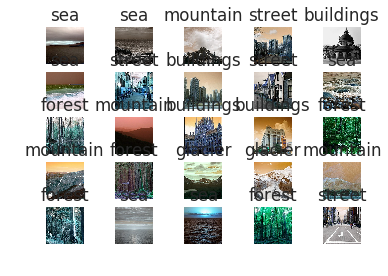

In [0]:
####### Executa ############################
# PLOTA IMAGENS
#
plot_images()

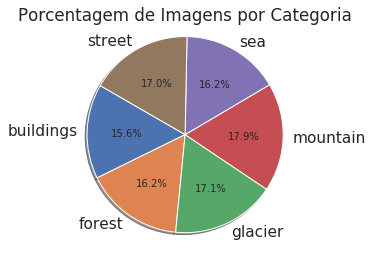

In [0]:
# PLOTA IMAGENS
#
pie_plot()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 148, 148, 200)     5600      
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 146, 146, 180)     324180    
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 29, 29, 180)       0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 27, 27, 180)       291780    
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 25, 25, 140)       226940    
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 23, 23, 100)       126100    
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 21, 21, 50)      

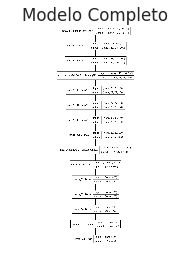

In [0]:
# CARREGA MODELO COMPLETO E PLOTA
#
plot_Model_Sequential_Completo()

In [0]:
# CARREGA MODELO COMPLETO E TREINA
#
get_Model_Sequential_Completo()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 148, 148, 200)     5600      
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 146, 146, 180)     324180    
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 29, 29, 180)       0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 27, 27, 180)       291780    
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 25, 25, 140)       226940    
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 23, 23, 100)       126100    
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 21, 21, 50)      

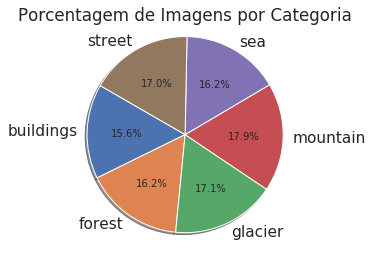

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 148, 148, 200)     5600      
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 146, 146, 180)     324180    
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 29, 29, 180)       0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 27, 27, 180)       291780    
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 25, 25, 140)       226940    
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 23, 23, 100)       126100    
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 21, 21, 50)      

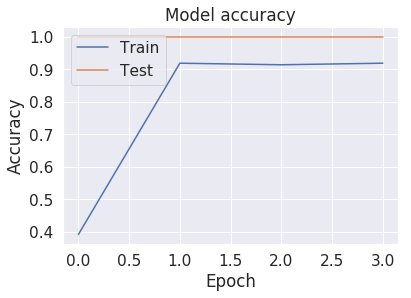

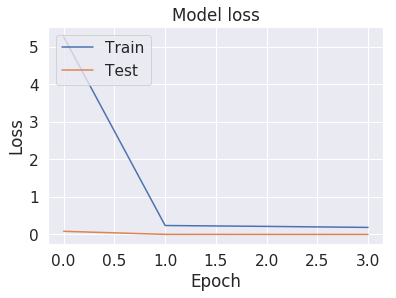

In [0]:
# CARREGA MODELO COMPLETO E TREINA
#
fit_Model_Sequential_Completo()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 148, 148, 200)     5600      
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 146, 146, 180)     324180    
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 29, 29, 180)       0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 27, 27, 180)       291780    
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 25, 25, 140)       226940    
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 23, 23, 100)       126100    
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 21, 21, 50)      

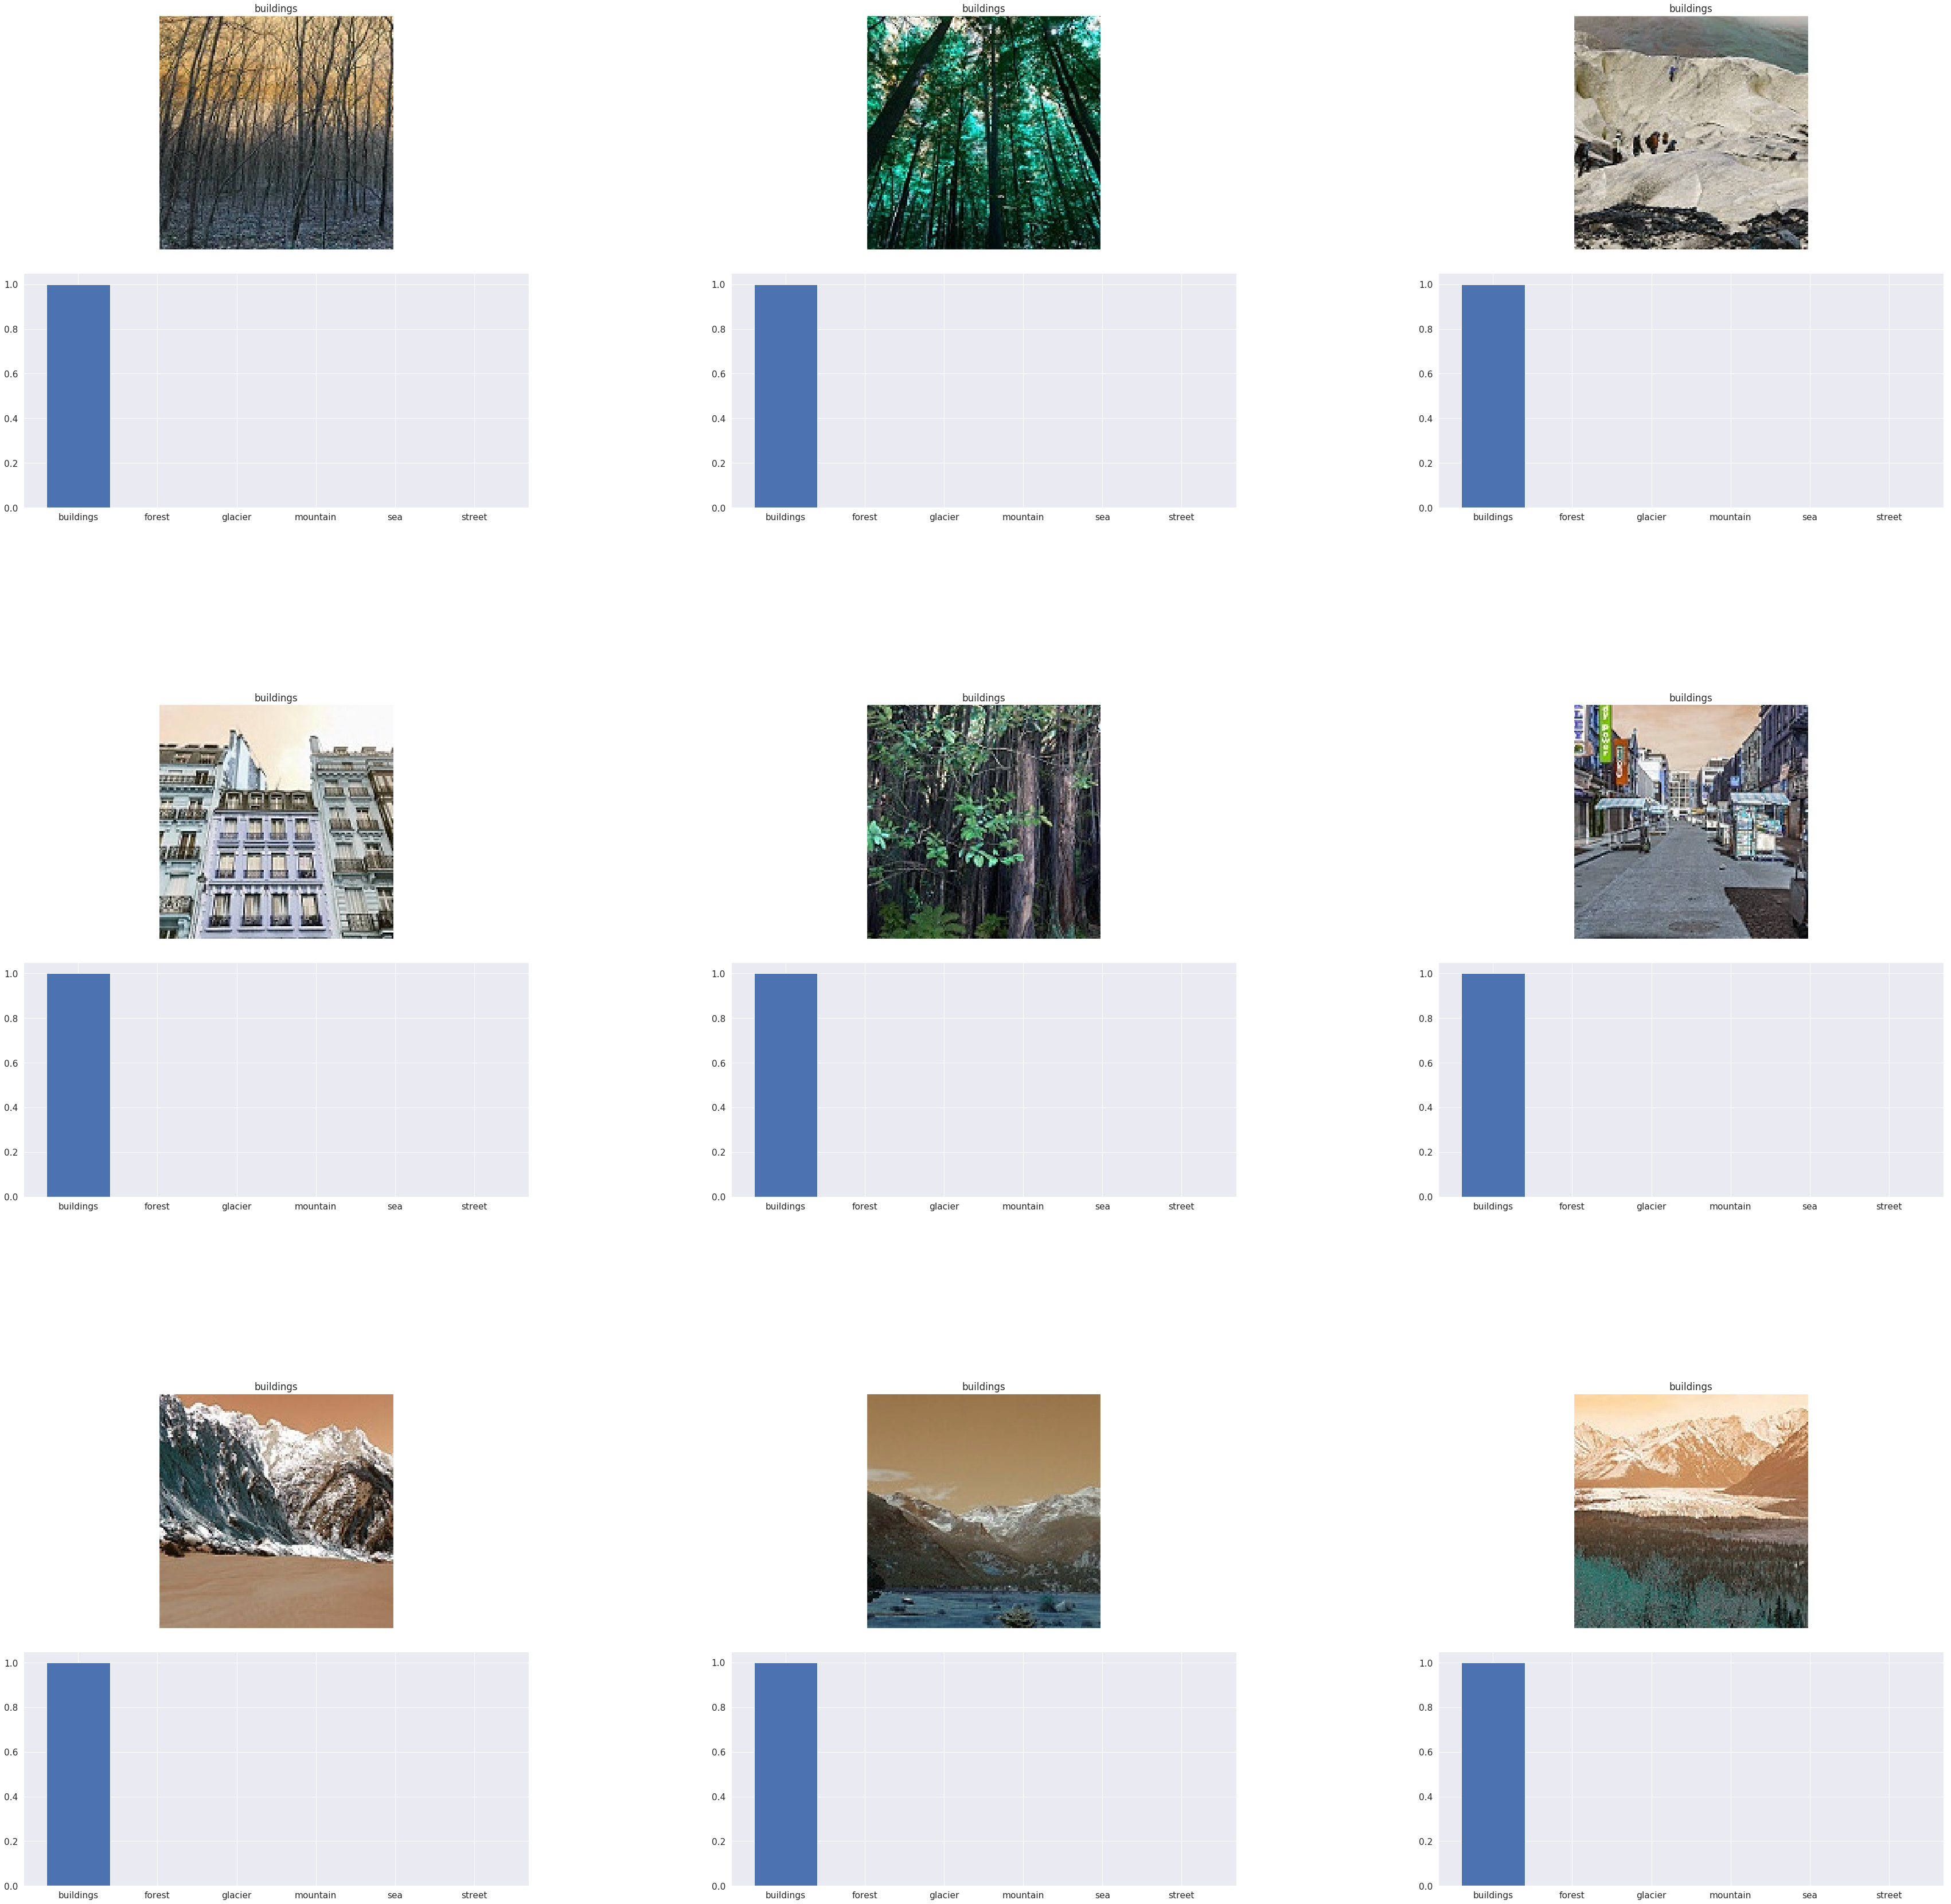

In [0]:
# CARREGA MODELO COMPLETO, PESOS E PREVE RESULTADOS
#
predict_Model_Sequential_Completo()

In [0]:
# MOSTRA PRECISAO DO MODELO

evaluate_Model_Sequential_Completo()

W0828 10:52:20.010060 140319389816704 util.py:244] Unresolved object in checkpoint: (root).optimizer.iter
W0828 10:52:20.014432 140319389816704 util.py:244] Unresolved object in checkpoint: (root).optimizer.beta_1
W0828 10:52:20.017102 140319389816704 util.py:244] Unresolved object in checkpoint: (root).optimizer.beta_2
W0828 10:52:20.019398 140319389816704 util.py:244] Unresolved object in checkpoint: (root).optimizer.decay
W0828 10:52:20.020534 140319389816704 util.py:244] Unresolved object in checkpoint: (root).optimizer.learning_rate
W0828 10:52:20.024927 140319389816704 util.py:244] Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.kernel
W0828 10:52:20.027427 140319389816704 util.py:244] Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.bias
W0828 10:52:20.030449 140319389816704 util.py:244] Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.kernel
W0

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 148, 148, 200)     5600      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 146, 146, 180)     324180    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 29, 29, 180)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 27, 27, 180)       291780    
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 25, 25, 140)       226940    
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 23, 23, 100)       126100    
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 21, 21, 50)       

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 148, 148, 200)     5600      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 146, 146, 180)     324180    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 29, 29, 180)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 27, 27, 180)       291780    
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 25, 25, 140)       226940    
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 23, 23, 100)       126100    
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 21, 21, 50)       

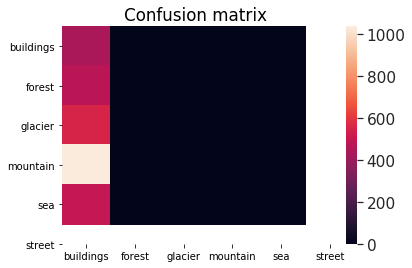

In [0]:
# MOSTRA PRECISAO DO MODELO

plot_confusion_matrix()